# Deblurring images

This notebook presents an example illustrating some techniques used for deblurring images.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## convert a 2-d image into a 1-d vector
def vec(image):
    sh = image.shape
    return image.reshape((sh[0]*sh[1]))

## convert a 1-d vector into a 2-d image of the given shape
def im(x, shape):
    return x.reshape(shape)

## display a 1-d vector as a 2-d image
def display_vec(vec, shape, scale = 1):
    image = im(vec, shape)
    plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
    plt.axis('off')
    plt.show()
    
## write a 1-d vector as a 2-d image file
def save_vec(vec, shape, filename, scale = 1):
    image = im(vec, shape)
    plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    
## a helper function for creating the blurring operator
def get_column_sum(spread):
    length = 40
    raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                    for i in range(length) for j in range(length)])
    return np.sum(raw[raw > 0.0001])

## blurs a single pixel at center with a specified Gaussian spread
def P(spread, center, shape):
    image = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
            if v < 0.0001:
                continue
            image[i,j] = v
    return image

## matrix multiplication where A operates on a 2-d image producing a new 2-d image
def image_mult(A, image, shape):
    return im( A @ vec(image), shape)

## construct our vector x_true
def build_x_true():
    dx = 5
    dy = 5
    up_width = 5
    bar_width= 3
    size = 32

    h_im = np.zeros((size, size))
    for i in range(size):
        if i < dy or i > size-dy:
            continue
        for j in range(size):
            if j < dx or j > size - dx:
                continue
            if j < dx + up_width or j > size - dx - up_width:
                h_im[i, j] = 1
            if abs(i - size/2) < bar_width:
                h_im[i, j] = 1

    x_exact = vec(h_im)
    return x_exact

## construct our blurring matrix with a Gaussian spread and zero boundary conditions
def build_A(spread, shape):
    #normalize = get_column_sum(spread)
    m = shape[0]
    n = shape[1]
    A = np.zeros((m*n, m*n))
    count = 0
    for i in range(m):
        for j in range(n):
            column = vec(P(spread, [i, j],  shape))
            A[:, count] = column
            count += 1
    normalize = np.sum(A[:, int(m*n/2 + n/2)])
    A = 1/normalize * A
    return A

## Basic data

Our images will be $32\times32$, and the Gaussian blur has a spatially invariant spread of $(5,5)$.  Then build $x^{\rm true}$ and the blurring operator $A$.

In [3]:
spread = [5,5]
size = 32
shape = (size, size)
pixels = shape[0] * shape[1]

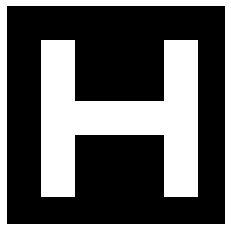

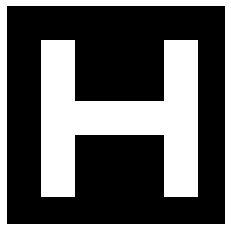

In [4]:
x_true= build_x_true()
display_vec(x_true, shape)
save_vec(x_true, shape, 'x_true.png')

The blurring operator is represented by the matrix $A$, one column of which is represented below.

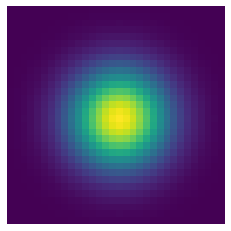

In [5]:
A = build_A(spread, shape)
plt.imshow(im(A[:, int(shape[0]**2/2 + shape[1]/2)], (size, size)))
plt.axis('off')
plt.show()

## Effect on a single pixel

To demonstrate the effect of the blurring operator, a single pixel is fully illuminated in the following image.

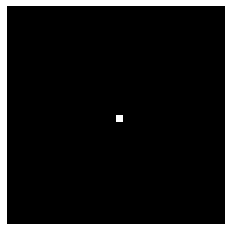

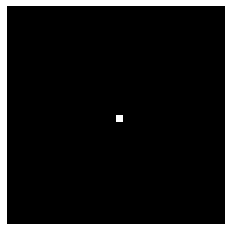

In [6]:
pixel = np.zeros(pixels)
pixel[528] = 1
display_vec(pixel, shape)
save_vec(pixel, shape, 'single-pixel.png')

Now we see the effect of the blurring operator on that one pixel.

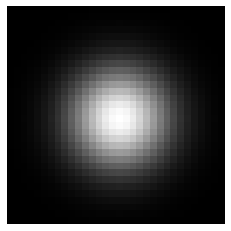

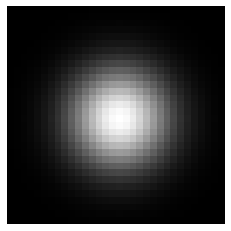

In [7]:
display_vec(A @ pixel, shape)
save_vec(A@pixel, shape, 'blurred-pixel.png')

## Construct images

Let's now return to our image ${\mathbf x}^{\rm true}$.

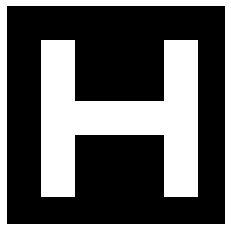

In [8]:
display_vec(x_true, shape)

Blurring ${\mathbf x}^{\rm true}$ results in the image represented by ${\mathbf b}^{\rm true}$.

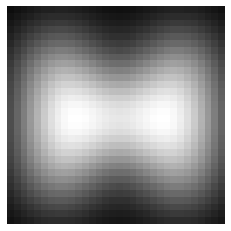

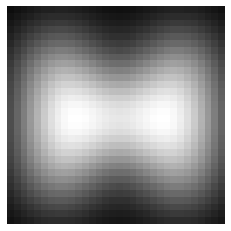

In [9]:
b_true = A @ x_true
display_vec(b_true, shape)
save_vec(b_true, shape, 'b_true.png')

Let's now add some Gaussian noise ${\mathbf e}$ to obtain ${\mathbf b} = {\mathbf e} + {\mathbf b}^{\rm true}$.  The size of the noise is small:  $\|{\mathbf e}\|_2 = 0.001\|{\mathbf b}\|_2$.  

Notice there is no apparent visual difference between ${\mathbf b}$ and ${\mathbf b}^{\rm true}$.

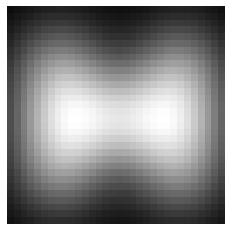

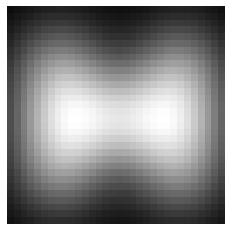

In [10]:
noise = np.random.randn(pixels)
e = 0.001 * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
b = b_true + e
display_vec(b, shape)
save_vec(b, shape, 'b.png')

We'll now try to reconstruct the original image ${\mathbf x}^{\rm true}$ by solving the equation $A{\mathbf x} = {\mathbf b}$.  Notice that the reconstruction bears little resemblence to ${\mathbf x}^{\rm true}$.

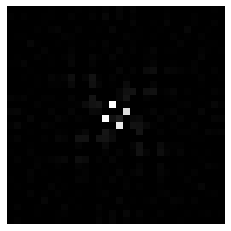

In [11]:
reconstruct = np.linalg.solve(A, b)
diff = np.max(reconstruct) - np.min(reconstruct)         
save_vec(reconstruct, shape, 'x_naive.png')

## SVD of A

To explain this behavior, let's look at a singular value decomposition of $A$.  

Notice how the singular values $\sigma_i$ becomes very small as $i$ grows.  The range of the singular values, roughly spanning $10^{-11}$ to $10^{0}$, explains why the equation $A{\mathbf x} = {\mathbf b}$ is ill-conditioned.

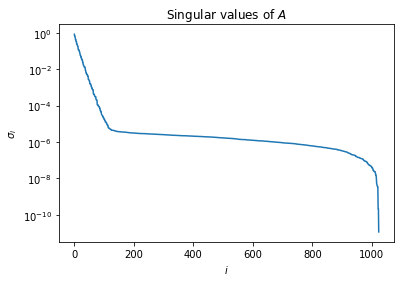

In [12]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.semilogy(S)
plt.title('Singular values of $A$')
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.savefig('singular_values.png', bbox_inches='tight')
plt.show()

Notice how the components of ${\mathbf b}^{\rm true}$, when expressed in a basis of left singular vectors ${\mathbf u}_i$, roughly follow the singular values $\sigma_i$.  This is an illustration of the *discrete Picard condition.*

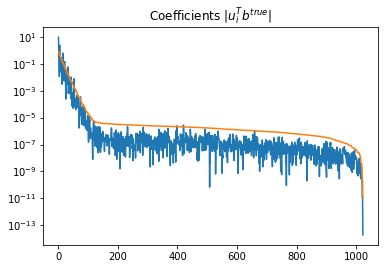

In [13]:
plt.semilogy(np.abs(U.T @ b_true))
plt.semilogy(S)
plt.title('Coefficients $|u_i^Tb^{true}|$')
plt.savefig('UTb_true.png', bbox_inches='tight')
plt.show()

We see, however, that the components of ${\mathbf b}$ in this basis remain roughly constant due to the noise contributed by ${\mathbf e}$.

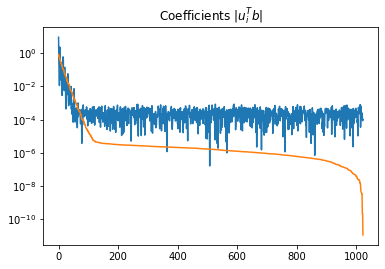

In [14]:
plt.semilogy(np.abs(U.T @ b))
plt.semilogy(S)
plt.title('Coefficients $|u_i^Tb|$')
plt.savefig('UTb.png', bbox_inches='tight')
plt.show()

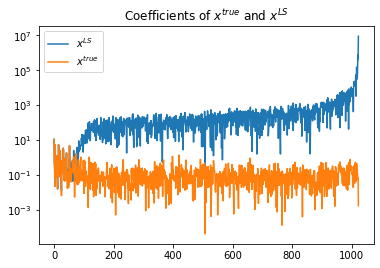

In [22]:
plt.semilogy(np.abs(1/S * (U.T @ b)), label="$x^{LS}$")
plt.semilogy(np.abs(1/S * (U.T @ b_true)), label="$x^{true}$")
plt.title('Coefficients of $x^{true}$ and $x^{LS}$')
plt.legend()
plt.savefig('VTx-ls.png', bbox_inches='tight')
plt.show()

The third condition for a discrete ill-posed problem is that the singular vectors ${\mathbf v}_i$ grow more oscillatory as $i$ grows.  Notice how the singular vectors ${\mathbf v}_i$ with larger $i$ show more oscillatory behavior.

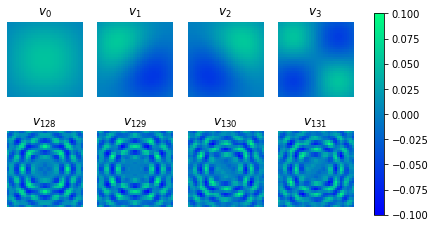

In [42]:
n = 2
m = 4
fig, axes = plt.subplots(n, m)
v_i = [V[:, k] for k in range(m)]
v_i += [V[:, k] for k in range(128, 128+m)]
right_singular = np.array(v_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(n):
    for j in range(m):
        image = axes[i][j].imshow(im(-V[:, k], (size, size)), vmin=immin, vmax=immax, cmap='winter')
        axes[i][j].axis('off')
        axes[i][j].set_title(r'$v_{' + str(k) + r'}$')
        k += 1
    k = 128
plt.subplots_adjust(bottom=0, top=0.7, left = 0, right=1)
fig.colorbar(image, ax=axes.ravel().tolist())
plt.savefig('v_vectors.png', bbox_inches='tight')
plt.show()

## Tikhonov regularization

We'll now look at the regularized solutions ${\mathbf x}^{\rm reg}$, obtained by Tikhonov regularization, for a range of regularization parameters $\lambda$.  We choose the parameter $\lambda$ that minimizes the difference $\|{\mathbf x}^{\rm true}-{\mathbf x}^{\rm reg}\|_2$.  Of course, this isn't possible in practice since we don't know ${\mathbf x}^{\rm true}$.

The next cell displays ${\mathbf x}^{\rm reg}$ with this optimal parameter.  It also produces the optimal value of $\lambda$ along with the residual $\|A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2$ and the norm $\|{\mathbf x}^{\rm reg}\|_2$ for the optimal $\lambda$.

Minima:
Lambda   =  0.00030517578125
residual =  0.009116212944952996
x_norm   =  16.065036224094854


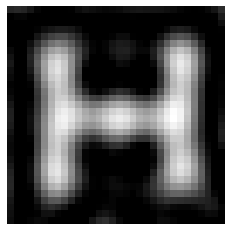

In [37]:
lamb = 10
minerror = 10000
xnorms = []
residuals = []
while lamb > 1e-08:
    F = np.array([s/(s**2 + lamb**2) for s in S])
    x_reg = V @ np.diag(F) @ U.T @ b
    xnorms.append(np.linalg.norm(x_reg))
    residuals.append(np.linalg.norm(A @ x_reg - b))
    error = np.linalg.norm(x_reg - x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minx = x_reg
        minxnorm = xnorms[-1]
        minresidual = residuals[-1]
    
    lamb /= 2

print('Minima:')
print('Lambda   = ', minlamb)
print('residual = ', minresidual)
print('x_norm   = ', minxnorm)

save_vec(minx, shape, 'x_reg.png')
display_vec(minx, shape)

Now we'll construct the $L$-curve, which is a plot of the residual $\|A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2$ and norm $\|{\mathbf x}^{\rm reg}\|_2$ as we vary $\lambda$.  Notice that the optimal $\lambda$ occurs when 
$\|A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2 =  0.0091$ and $\|{\mathbf x}^{\rm reg}\|_2 = 16.1$, which is the corner of the "L".  This provides a means of identifying the optimal regularized solution ${\mathbf x}^{\rm reg}$ when we don't know ${\mathbf x}^{\rm true}$.

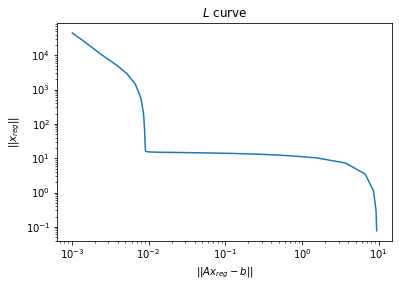

In [268]:
plt.loglog(residuals, xnorms)
plt.title('$L$ curve')
plt.xlabel('$||Ax^{reg} - b||$')
plt.ylabel('$||x^{reg}||$')
plt.savefig('L-curve.png', bbox_inches='tight')
plt.show()